# Santander Kaggle competition

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import xgboost as xgb
%matplotlib inline

In [2]:
train_data = pd.read_csv('train-2.csv')
test_data = pd.read_csv('test-2.csv')
sample_submission = pd.read_csv('sample_submission-3.csv')

## Cleaning data and dimensionality reduction : 

In [38]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.8 MB


In [39]:
id_test = test_data['ID']
target = train_data['TARGET'].values
X_train = train_data.drop(['ID','TARGET'], axis=1)
X_test = test_data.drop(['ID'], axis=1).values
X_test.shape

(75818, 369)

In [40]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train,target)
clf.feature_importances_
model = SelectFromModel(clf,prefit=True)
Xr_Train = model.transform(X_train)
Xr_Test = model.transform(X_test)

In [41]:
Xr_Test.shape

(75818, 51)

## Data Visualization : 

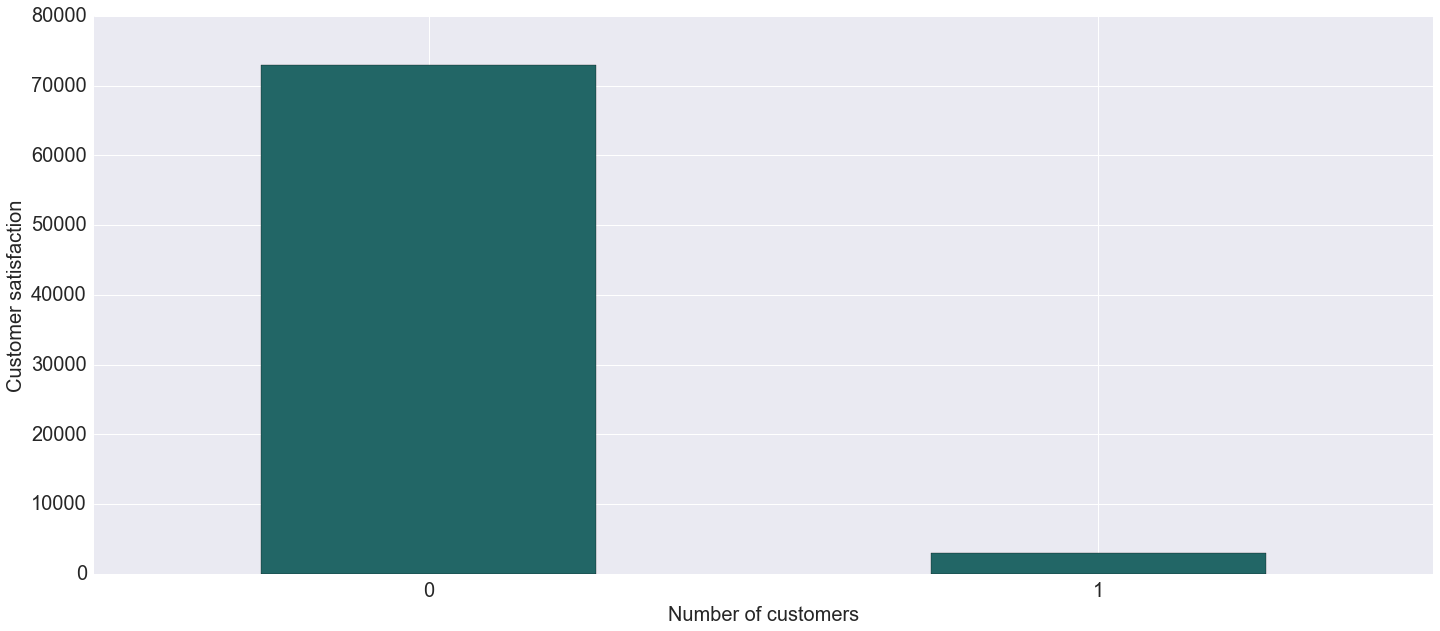

In [42]:
train_data.TARGET.value_counts().plot(kind='bar',color='#226666',rot=0,figsize=(24,10),fontsize=20)
plt.xlabel("Number of customers",fontsize = 20)
plt.ylabel("Customer satisfaction",fontsize = 20)

## Random Forest Classifier

In [49]:
clf = RandomForestClassifier(n_estimators=120, max_depth=17, random_state=1)
clf.fit(Xr_Train, target)
y_pred = clf.predict_proba(Xr_Test)
scores = cross_validation.cross_val_score(clf, Xr_Train, target, scoring='roc_auc', cv=5) 
print(scores.mean())
submission = pd.DataFrame({"ID":id_test, "TARGET":y_pred[:,1]})
submission.to_csv("submission_rfc.csv", index=False)

0.831430587926


## XGB Classifier 

In [75]:
xgbClassifier = xgb.XGBClassifier(n_estimators=580, max_depth=5, seed=1234, missing=np.nan, learning_rate=0.02, subsample=0.7, colsample_bytree=0.7, objective='binary:logistic') 
#xgbClassifier = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=580, learning_rate=0.03, nthread=4, subsample=0.95, colsample_bytree=0.85, seed=4242)
xgbClassifier.fit(Xr_Train,target)
y_xgb_pred = xgbClassifier.predict_proba(Xr_Test)
scores = cross_validation.cross_val_score(xgbClassifier, Xr_Train, target, scoring='roc_auc', cv=5) 
print(scores.mean())

0.839785621284


In [76]:
submission = pd.DataFrame({"ID":id_test, "TARGET":y_xgb_pred[:,1]})
submission.to_csv("submission_rfc.csv", index=False)

## Ensemble Methods
The goal of this approach is to build an ensemble classifer based of many ML algorithm, this model is based of <b>Hard Voting Classifier </b> in order to determin the target of every classes, for the moment we try to build this model using a <b> Random Forest Classifier </b> and <b> Xgboost Classifier </b>. 

In [77]:
eclf1 = VotingClassifier(estimators=[('rf', clf), ('xgb', xgbClassifier)], voting='hard')
eclf1.fit(Xr_Train,target)
ens_predict = eclf1.predict(Xr_Train)

In [73]:
for clf, label in zip([clf, xgbClassifier, eclf1], ['Random Forest', 'XGB Classifier', 'Ensemble']):
    scores = cross_validation.cross_val_score(clf, Xr_Train, target, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.96 (+/- 0.00) [Random Forest]
Accuracy: 0.96 (+/- 0.00) [XGB Classifier]
Accuracy: 0.96 (+/- 0.00) [Ensemble]
